In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set figure size to (12, 6)
plt.rcParams['figure.figsize'] = (12,6)

# Step 1 - Load and prepare the data

In [2]:
df = pd.read_csv('/Users/braulio/Documents/data/ECA_blended_custom/temp_data.txt')
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52777 entries, 0 to 52776
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SOUID     52777 non-null  int64
 1       DATE  52777 non-null  int64
 2      TG     52777 non-null  int64
 3    Q_TG     52777 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB


## Temperature Forecast I
Discuss the following questions:

1. What does the temperature forecast for Berlin for any given day depend on? The year? Is there an underlying trend the temperature follows? The day of the year? Does the temperature depend on the season of the year? The temperature of the previous day? Is the present able to explain part of the (near) future?
2. If we know the day of the year, the year and the temperature of the previous day, are we able to perfectly predict the temperature of any given day in Berlin?

## Plot the time series

In [4]:
df.columns

Index(['SOUID', '    DATE', '   TG', ' Q_TG'], dtype='object')

In [5]:
# pd.to_datetime(df['DATE'])
df.columns = ['Source_ID', 'DATE', 'Mean_temp', 'q_tg']

In [6]:
df["datetime"] = pd.to_datetime(df["DATE"], format='%Y%m%d')

In [7]:
df.head()

,Source_ID,DATE,Mean_temp,q_tg,datetime
0,127488,18760101,22,0,1876-01-01
1,127488,18760102,25,0,1876-01-02
2,127488,18760103,3,0,1876-01-03
3,127488,18760104,-58,0,1876-01-04
4,127488,18760105,-98,0,1876-01-05


In [8]:
df['day'] = df['datetime'].dt.day

df['month'] = df['datetime'].dt.month

df['year'] = df['datetime'].dt.year

In [9]:
df = df.drop('DATE', 1)
df.set_index('datetime', inplace=True)
df.head()

,Source_ID,Mean_temp,q_tg,day,month,year
datetime,,,,,,
1876-01-01,127488,22,0,1,1,1876
1876-01-02,127488,25,0,2,1,1876
1876-01-03,127488,3,0,3,1,1876
1876-01-04,127488,-58,0,4,1,1876
1876-01-05,127488,-98,0,5,1,1876


In [10]:
## CONVERT MEAN_TEMP TO KELVIN TO AVOID FUTURE 0 DIVISIONS
df.loc[:,'Mean_temp'] *= 0.1
df.loc[:,'Mean_temp'] += 273.15

df.head()

,Source_ID,Mean_temp,q_tg,day,month,year
datetime,,,,,,
1876-01-01,127488,275.35,0,1,1,1876
1876-01-02,127488,275.65,0,2,1,1876
1876-01-03,127488,273.45,0,3,1,1876
1876-01-04,127488,267.35,0,4,1,1876
1876-01-05,127488,263.35,0,5,1,1876


In [11]:
df.describe()

,Source_ID,Mean_temp,q_tg,day,month,year
count,52777.000000,52777.000000,52777.000000,52777.000000,52777.000000,52777.000000
mean,124188.602156,278.807978,0.033253,15.729200,6.512591,1947.749891
std,4334.752786,61.737913,0.546057,8.799957,3.448779,41.713849
min,111448.000000,-726.750000,0.000000,1.000000,1.000000,1876.000000
25%,121152.000000,276.450000,0.000000,8.000000,4.000000,1912.000000
50%,127488.000000,282.450000,0.000000,16.000000,7.000000,1948.000000
75%,127488.000000,288.850000,0.000000,23.000000,10.000000,1984.000000
max,127848.000000,303.950000,9.000000,31.000000,12.000000,2020.000000


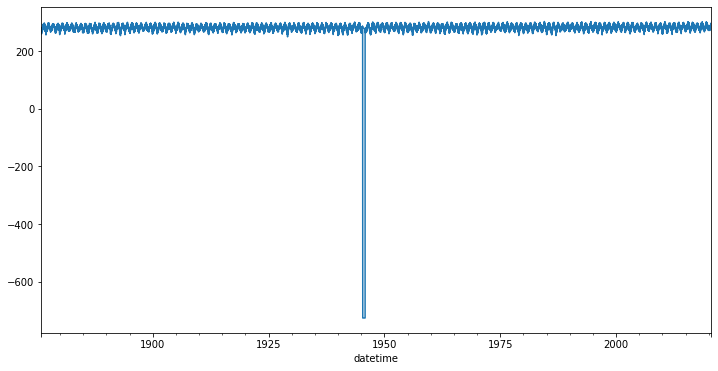

In [12]:
# Plot the series
df['Mean_temp'].plot()

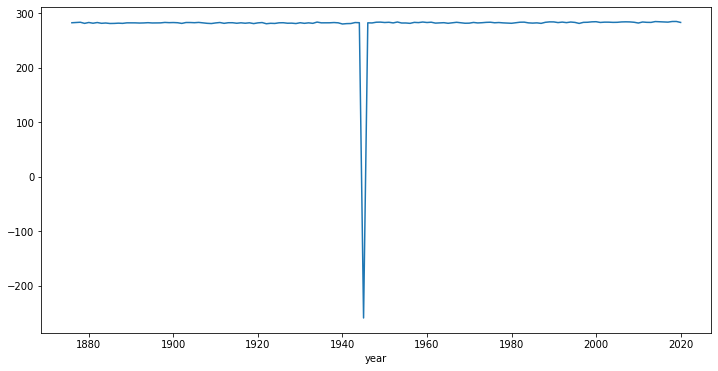

In [13]:
df.groupby('year').mean()['Mean_temp'].plot()

In [14]:
df = df.loc[df['Mean_temp'] > -100]

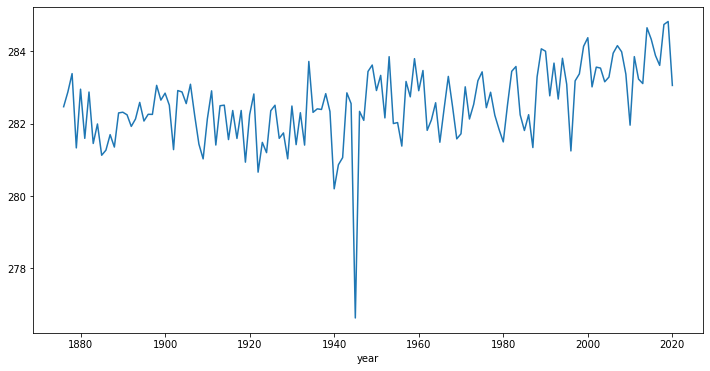

In [15]:
df.groupby('year').mean()['Mean_temp'].plot()

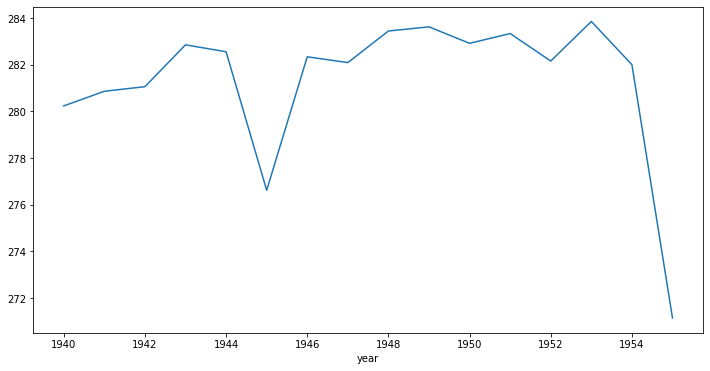

In [16]:
df2 = df[(df.index > '1940-01-01') & (df.index <= '1955-01-01')]

df2.groupby('year').mean()['Mean_temp'].plot()

### dataframe selection:

use data only from 1946 on, since there is an Abnormality with temp data from year 1945, and enough data to continue without previous years.

In [17]:
df = df[df.index >= '1946-01-01']

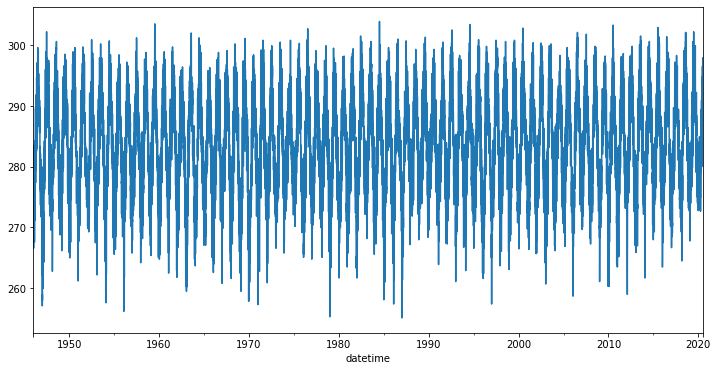

In [18]:
df['Mean_temp'].plot()

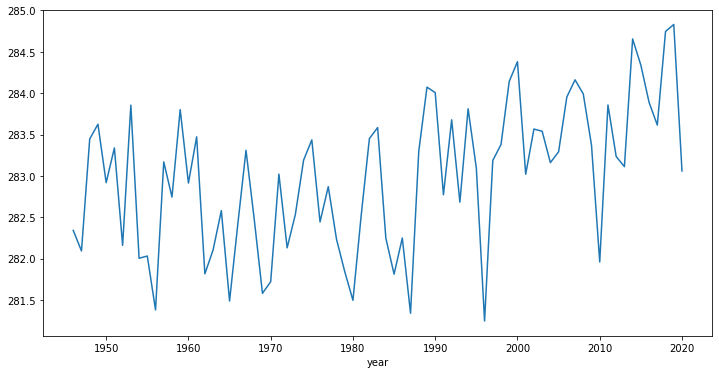

In [19]:
df.groupby('year').mean()['Mean_temp'].plot()

# Step 2 - Split the time series into training and test set

In [20]:
df.tail()

,Source_ID,Mean_temp,q_tg,day,month,year
datetime,,,,,,
2020-06-26,121152,296.05,0,26,6,2020
2020-06-27,121152,297.95,0,27,6,2020
2020-06-28,121152,294.95,0,28,6,2020
2020-06-29,121152,291.75,0,29,6,2020
2020-06-30,121152,292.35,0,30,6,2020


In [21]:
# If we have a DatetimeIndex as our DataFrame.index, we can use that To slice by dates
y_train = df[:'2019-06-30'].copy()
y_test = df['2019-07-01':'2020-06-30'].copy()

In [22]:
y_train.shape, y_test.shape

((26844, 6), (366, 6))

# Step 3 - Detrend your time series data

In [23]:
# Create the pct_change
y_train['pct_change'] = y_train['Mean_temp'].pct_change()

y_train

,Source_ID,Mean_temp,q_tg,day,month,year,pct_change
datetime,,,,,,,
1946-01-01,127488,269.75,0,1,1,1946,NaN
1946-01-02,127488,270.15,0,2,1,1946,0.001483
1946-01-03,127488,270.35,0,3,1,1946,0.000740
1946-01-04,127488,270.45,0,4,1,1946,0.000370
1946-01-05,127488,274.55,0,5,1,1946,0.015160
...,...,...,...,...,...,...,...
2019-06-26,121152,302.25,0,26,6,2019,0.006661
2019-06-27,121152,292.65,0,27,6,2019,-0.031762
2019-06-28,121152,291.75,0,28,6,2019,-0.003075


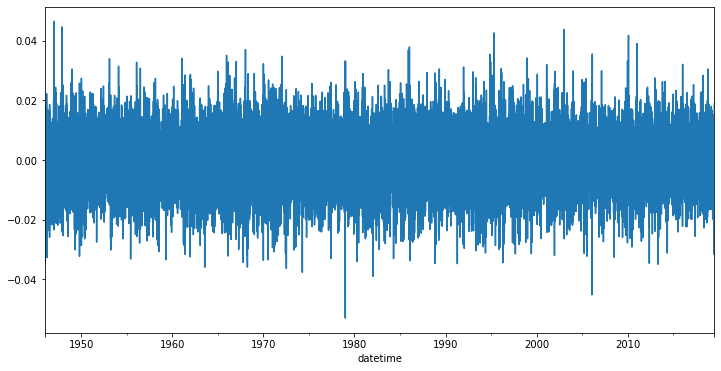

In [24]:
# Plot the pct_change
y_train['pct_change'].plot()

# Step 4 - De-seasonalize the series by subtracting monthly means

In [25]:
# Create monthly means of the pct_change
y_train['monthly_means'] = y_train.groupby('month')['pct_change'].transform('mean')

y_train.head(5)

,Source_ID,Mean_temp,q_tg,day,month,year,pct_change,monthly_means
datetime,,,,,,,,
1946-01-01,127488,269.75,0,1,1,1946,NaN,0.000035
1946-01-02,127488,270.15,0,2,1,1946,0.001483,0.000035
1946-01-03,127488,270.35,0,3,1,1946,0.000740,0.000035
1946-01-04,127488,270.45,0,4,1,1946,0.000370,0.000035
1946-01-05,127488,274.55,0,5,1,1946,0.015160,0.000035


In [26]:
# Subtract the monthly mean from the actual values
y_train['deseasonalized'] = y_train['pct_change'] - y_train['monthly_means']

y_train.head()

,Source_ID,Mean_temp,q_tg,day,month,year,pct_change,monthly_means,deseasonalized
datetime,,,,,,,,,
1946-01-01,127488,269.75,0,1,1,1946,NaN,0.000035,NaN
1946-01-02,127488,270.15,0,2,1,1946,0.001483,0.000035,0.001448
1946-01-03,127488,270.35,0,3,1,1946,0.000740,0.000035,0.000705
1946-01-04,127488,270.45,0,4,1,1946,0.000370,0.000035,0.000335
1946-01-05,127488,274.55,0,5,1,1946,0.015160,0.000035,0.015125


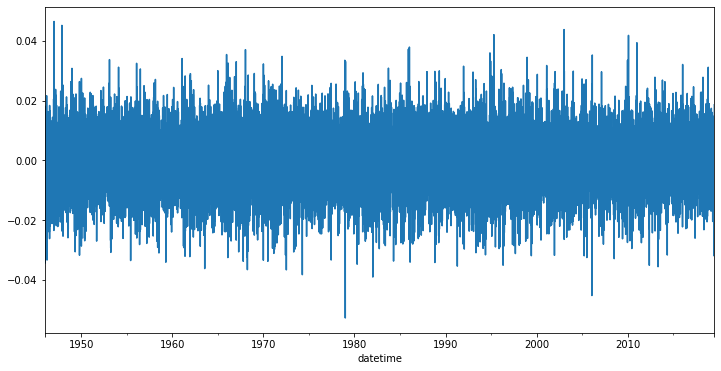

In [27]:
# Plot the deseasonalized data
y_train['deseasonalized'].plot()

## The mean of the time series

In [28]:
y_train['Mean_temp'].mean()

282.9664282521246

In [29]:
# Add the mean value of passengers as prediction for y_test
y_test['y_pred_mean'] = y_train['Mean_temp'].mean()

y_test.head(5)

,Source_ID,Mean_temp,q_tg,day,month,year,y_pred_mean
datetime,,,,,,,
2019-07-01,121152,295.55,0,1,7,2019,282.966428
2019-07-02,121152,290.85,0,2,7,2019,282.966428
2019-07-03,121152,288.55,0,3,7,2019,282.966428
2019-07-04,121152,290.05,0,4,7,2019,282.966428
2019-07-05,121152,291.35,0,5,7,2019,282.966428


In [30]:
# Define a function that plots the forecast for us

def plot_forecast(y_train, y_test, columns):
    '''
    Plots forecasts of passenger data
    
    Params:
    -------
    y_train: The training data
    y_test: The test data
    columns: Name of the prediction columns form a DataFrame
    
    '''
    # Plot the actual values
    y_train.Mean_temp.plot(label='Training Data')
    y_test.Mean_temp.plot(label=('Test Data'))
    
    # Plot each prediction
    for column in columns:
        y_test[column].plot(label=column)
    
    # General settings
    plt.title('Average temperature over Time', fontsize=15)
    plt.ylabel('Mean temperature', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend()
    # plt.savefig('mean_baseline.png')
    plt.show()

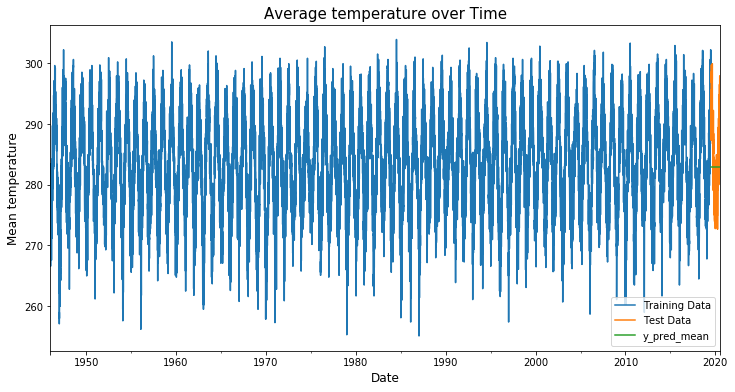

In [31]:
# Plot the forecast
plot_forecast(y_train, y_test, ['y_pred_mean'])

## The mean of the detrended time series

In [32]:
# Take the mean percentage change
y_test['y_pred_mean_pct_change'] = y_train['pct_change'].mean()

y_test.head()

,Source_ID,Mean_temp,q_tg,day,month,year,y_pred_mean,y_pred_mean_pct_change
datetime,,,,,,,,
2019-07-01,121152,295.55,0,1,7,2019,282.966428,0.000041
2019-07-02,121152,290.85,0,2,7,2019,282.966428,0.000041
2019-07-03,121152,288.55,0,3,7,2019,282.966428,0.000041
2019-07-04,121152,290.05,0,4,7,2019,282.966428,0.000041
2019-07-05,121152,291.35,0,5,7,2019,282.966428,0.000041


### Convert the prediction back to Mean Temperature

In [33]:
# Add 1 to y_pred_mean_diff
y_test['y_pred_mean_pct_change'] += 1

y_test.head(3)

,Source_ID,Mean_temp,q_tg,day,month,year,y_pred_mean,y_pred_mean_pct_change
datetime,,,,,,,,
2019-07-01,121152,295.55,0,1,7,2019,282.966428,1.000041
2019-07-02,121152,290.85,0,2,7,2019,282.966428,1.000041
2019-07-03,121152,288.55,0,3,7,2019,282.966428,1.000041


In [34]:
# Take the cumulative product of the series
y_test['y_pred_mean_pct_change'] = np.cumprod(y_test['y_pred_mean_pct_change'])

y_test.head()

,Source_ID,Mean_temp,q_tg,day,month,year,y_pred_mean,y_pred_mean_pct_change
datetime,,,,,,,,
2019-07-01,121152,295.55,0,1,7,2019,282.966428,1.000041
2019-07-02,121152,290.85,0,2,7,2019,282.966428,1.000083
2019-07-03,121152,288.55,0,3,7,2019,282.966428,1.000124
2019-07-04,121152,290.05,0,4,7,2019,282.966428,1.000166
2019-07-05,121152,291.35,0,5,7,2019,282.966428,1.000207


In [35]:
# Take the last actual observation as starting point
last_observation = y_train['Mean_temp'][-1]
last_observation

302.04999999999995

In [36]:
y_test['y_pred_mean_pct_change'] *= last_observation

y_test.head()

,Source_ID,Mean_temp,q_tg,day,month,year,y_pred_mean,y_pred_mean_pct_change
datetime,,,,,,,,
2019-07-01,121152,295.55,0,1,7,2019,282.966428,302.062507
2019-07-02,121152,290.85,0,2,7,2019,282.966428,302.075014
2019-07-03,121152,288.55,0,3,7,2019,282.966428,302.087521
2019-07-04,121152,290.05,0,4,7,2019,282.966428,302.100030
2019-07-05,121152,291.35,0,5,7,2019,282.966428,302.112538


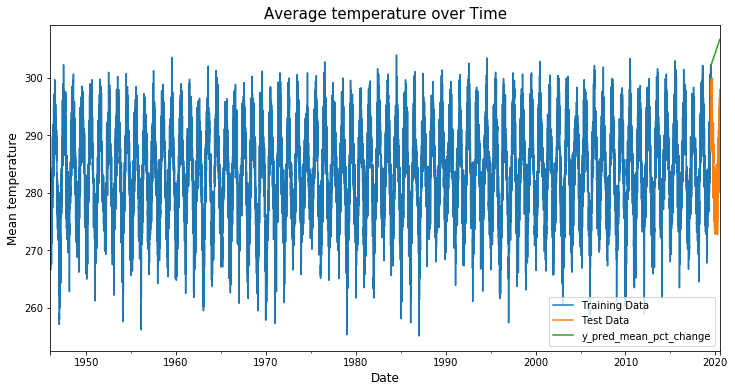

In [37]:
# Plot the forecast
plot_forecast(y_train, y_test, ['y_pred_mean_pct_change'])

## Temperature Forecast II
Which information is most useful for predicting tomorrows temperature in Berlin?

The temperature in Berlin one year ago?

The long term average temperature in Berlin of tomorrows date?

Todays temperature in Berlin?